In [1]:
import time
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import tushare as ts
ts.set_token('29eaf3bcac23df4c6d025de157ab2d53beead3391fbe6e83b4ebcb6c')
pro = ts.pro_api()

import mpl_finance as mpf
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.pylab import date2num
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
sns.set()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'SimHei'

D:\Users\admin\Anaconda3\envs\py37-stock\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [2]:
from mylab.stock.myread import *
from mylab.stock.myfeature import *
from mylab.stock.myplot import *
from mylab.stock.my3point import *


In [3]:
SAVE_CSV = True
LOCAL = not True

GET_DAILY = True
SELECT_STOCK = True

start_date = "20160101"
end_date = "20200413"

# get all Stocks Info

In [4]:
#获取基础信息数据，包括股票代码、名称、上市日期、退市日期等
pool_df = getStockBasic(LOCAL = False,noSTKC = True, list_data = "20180101")
# pool_df = pd.read_csv("./data/stock/blue_stock_rank_3.csv" )

print('获得上市股票总数：', len(pool_df)-1)
pool_df.head()

获得上市股票总数： 2640


,ts_code,symbol,name,area,industry,market,exchange,list_status,list_date,delist_date
0,000001.SZ,000001,平安银行,深圳,银行,主板,SZSE,L,19910403,None
1,000002.SZ,000002,万科A,深圳,全国地产,主板,SZSE,L,19910129,None
2,000004.SZ,000004,国农科技,深圳,生物制药,主板,SZSE,L,19910114,None
3,000005.SZ,000005,世纪星源,深圳,环境保护,主板,SZSE,L,19901210,None
4,000006.SZ,000006,深振业A,深圳,区域地产,主板,SZSE,L,19920427,None


# plot demo

0

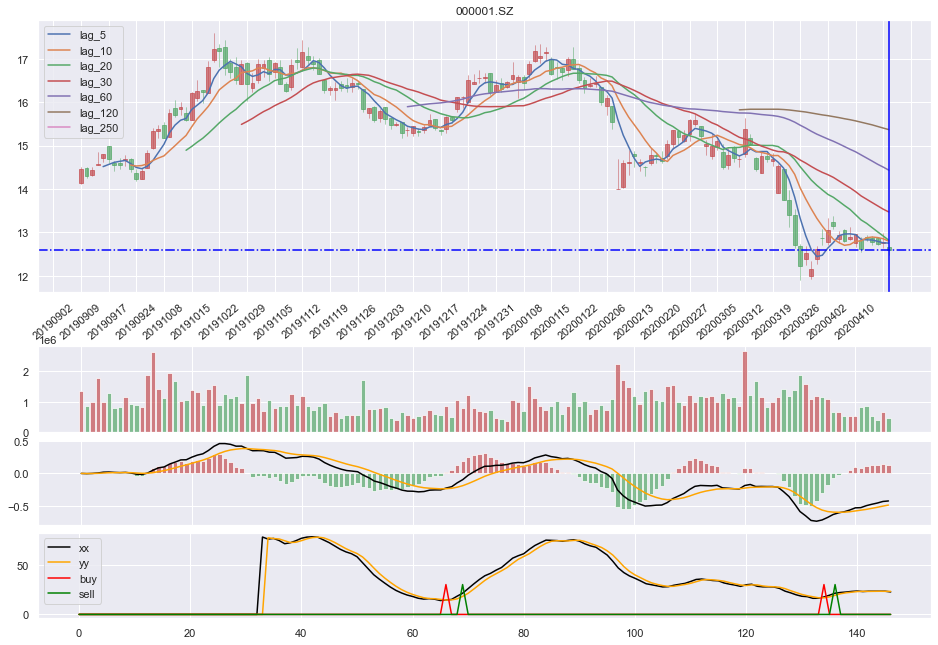

In [5]:
start_date = "20190901"
# end_date = "20200101"
stock_code = "000001.SZ"
save_dir = "./output/select_by_3_percent/"

stock_df = getStock(stock_code,start_date, end_date, LOCAL = True)
stock_df = get3Percent(stock_df)
plotStock3Pct(stock_df ,SAVE = False, save_dir =save_dir)

In [6]:
stock_df.loc[stock_df["trade_date"] == "20200410", "dates"].values[0]

145

In [7]:
stock_df.head()

,trade_date,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,...,trade_date2,dates,lag_5,lag_10,lag_20,lag_30,lag_60,lag_120,lag_250,up
0,20190902,000001.SZ,14.15,14.50,14.11,14.45,14.16,0.29,2.0480,1360201.30,...,737304.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,20190903,000001.SZ,14.48,14.51,14.25,14.30,14.45,-0.15,-1.0381,858653.65,...,737305.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,20190904,000001.SZ,14.32,14.50,14.31,14.44,14.30,0.14,0.9790,973964.87,...,737306.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,20190905,000001.SZ,14.56,14.85,14.55,14.58,14.44,0.14,0.9695,1768051.43,...,737307.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,20190906,000001.SZ,14.71,14.81,14.62,14.81,14.58,0.23,1.5775,986432.80,...,737308.0,4,14.516,NaN,NaN,NaN,NaN,NaN,NaN,1


# save all stocks in 3% state

In [8]:
def selectStockBy3Percent(df):
    select_num = np.any( [stock_df.buy_signal.values>0,
                          stock_df.sell_signal.values>0 ,
                         ],
                        axis = 0)   # IF( CROSS(xx,yy) AND xx<20 ,30,0);
    select_df = stock_df.loc[select_num,:]
    return select_df

In [9]:
# select all
start_date = "20100101"
# end_date = "20200101"
stock_code = "002499.SZ"
save_dir = "./output/select_by_3_percent/all_3_percent/"

for i in range(len(pool_df)):  # len(pool_df)
    stock_code = pool_df.loc[i,"ts_code"]
    stock_name = pool_df.loc[i,"name"]
    try:
        stock_df = getStock(stock_code,start_date, end_date, LOCAL = True)
        stock_df = get3Percent(stock_df)
        select_df = selectStockBy3Percent(stock_df )  # stock  
        select_df = select_df.reset_index()
        select_df = select_df.loc[1:,:]
        select_df.rename(columns = {"index":"pre_index"}, inplace = True)
        select_df.to_csv(save_dir+stock_code+".csv", index = False)
    except Exception as err:
        print(stock_code,stock_name,err)
    
print(select_df.shape)
select_df.head()

KeyboardInterrupt: 

# conduct the policy

In [10]:
from mylab.stock.mypolicy import actionDay
from mylab.stock.mypolicy import action3Per

In [95]:
def action3Per(stock_df,select_df,buy_day_ix):
    stock_ix = select_df.pre_index.values[buy_day_ix]
    # day 1
    select_df, sell = actionDay(stock_df,select_df,buy_day_ix,1)
    if not sell:
        select_df["sell_price"][buy_day_ix] = stock_df.close.values[ stock_ix +1 ] 
        select_df["hold_period"][buy_day_ix] = 1
        select_df["sell_reason"][buy_day_ix] = "get max period"
    return select_df
    

In [96]:
# policy
start_date = "20100101"
end_date = "20200430"
# stock_code = "002499.SZ"
save_dir = "./output/select_by_3_percent/reesult_policy2/"

for i in range(len(pool_df)):  # len(pool_df)
    stock_code = pool_df.loc[i,"ts_code"]
    stock_name = pool_df.loc[i,"name"]
    try:
        stock_df = getStock(stock_code,start_date, end_date, LOCAL = True)
        stock_df = get3Percent(stock_df)
        # select df 
        select_df = stock_df.loc[stock_df.buy_signal.values>0,:]
        # reindex select df otherwise wrong !!!
        select_df = select_df.iloc[1:-1,:]
        select_df = select_df.reset_index()
        select_df.rename(columns = {"index":"pre_index"}, inplace = True)
#         print(stock_code,stock_name,len(select_df))
    except Exception as err:
        print(stock_code,stock_name,err)
        
    try:
        # initiate columns
        select_df["postday_open"] = np.nan 
        select_df["postday_high"] = np.nan 
        select_df["postday_low"] = np.nan 
        select_df["postday_close"] = np.nan 
        select_df["postday_vol"] = np.nan 
        select_df["preday_open"] = np.nan 
        select_df["preday_high"] = np.nan 
        select_df["preday_low"] = np.nan 
        select_df["preday_close"] = np.nan 
        select_df["preday_vol"] = np.nan 
        select_df["buy_price"] = np.nan
        select_df["target_price"] = np.nan
        select_df["minimal_price"] = np.nan
        select_df["sell_price"] = np.nan
        select_df["hold_period"] = np.nan
        select_df["sell_reason"] = np.nan 
        for i in select_df.index.values:
            # policy
            stock_ix = select_df.pre_index.values[i] 
            # 15 天以内出现过两次底部突破 才符合条件
            if sum(stock_df.buy_signal.values[stock_ix-15:stock_ix-1]) == 0:
                continue
            # 当天涨停的股票不算
            if select_df.pct_chg.values[i] > 9.7:
                continue
            # save necessary information
            select_df.buy_price.values[i] = stock_df.close.values[stock_ix]
            select_df.target_price.values[i] = stock_df.close.values[stock_ix] *1.03 
            select_df.minimal_price.values[i] = stock_df.close.values[stock_ix] *0.97 
            select_df["postday_open"][i] = stock_df.open.values[stock_ix+1]
            select_df["postday_high"][i] = stock_df.high.values[stock_ix+1]
            select_df["postday_low"][i] = stock_df.low.values[stock_ix+1]
            select_df["postday_close"][i] = stock_df.close.values[stock_ix+1]
            select_df["postday_vol"][i] = stock_df.vol.values[stock_ix+1]
            select_df["preday_open"][i] = stock_df.open.values[stock_ix-1]
            select_df["preday_high"][i] = stock_df.high.values[stock_ix-1]
            select_df["preday_low"][i] = stock_df.low.values[stock_ix-1]
            select_df["preday_close"][i] = stock_df.close.values[stock_ix-1]
            select_df["preday_vol"][i] = stock_df.vol.values[stock_ix-1]
            # conduct policy
            select_df = action3Per(stock_df,select_df,i)
            
        # calculate some important inform after all buy-sell points are conducted
        select_df["earn_rate"] = (select_df["sell_price"]/select_df["buy_price"]-1)*100
        select_df["earn_rate_per_day"] = select_df["earn_rate"]/select_df["hold_period"]
        select_df["win"] = select_df["earn_rate"] > 0
        # drop nan and save
        select_df = select_df.dropna()
        if sum(select_df["earn_rate"]>3.1)>0:
            print("earn_rate >3 :",stock_code,stock_name,len(select_df))
        select_df.to_csv(save_dir+stock_code+".csv", index = False)
#         print(stock_code,stock_name,len(select_df))
    except Exception as err:
        print(stock_code,stock_name,err)
print(select_df.shape)
select_df.head(20)

earn_rate >3 : 000014.SZ 沙河股份 22
earn_rate >3 : 000021.SZ 深科技 20
earn_rate >3 : 000023.SZ 深天地A 17
earn_rate >3 : 000030.SZ 富奥股份 9
earn_rate >3 : 000058.SZ 深赛格 15
earn_rate >3 : 000070.SZ 特发信息 13
earn_rate >3 : 000417.SZ 合肥百货 15
earn_rate >3 : 000498.SZ 山东路桥 22
earn_rate >3 : 000513.SZ 丽珠集团 12
earn_rate >3 : 000520.SZ 长航凤凰 21
earn_rate >3 : 000524.SZ 岭南控股 13
earn_rate >3 : 000526.SZ 紫光学大 4
earn_rate >3 : 000540.SZ 中天金融 16
earn_rate >3 : 000545.SZ 金浦钛业 13
earn_rate >3 : 000557.SZ 西部创业 9
earn_rate >3 : 000559.SZ 万向钱潮 27
earn_rate >3 : 000563.SZ 陕国投A 14
earn_rate >3 : 000567.SZ 海德股份 23
earn_rate >3 : 000593.SZ 大通燃气 11
earn_rate >3 : 000603.SZ 盛达资源 26
earn_rate >3 : 000610.SZ 西安旅游 13
earn_rate >3 : 000616.SZ 海航投资 26
earn_rate >3 : 000627.SZ 天茂集团 26
earn_rate >3 : 000629.SZ 攀钢钒钛 26
earn_rate >3 : 000636.SZ 风华高科 16
earn_rate >3 : 000655.SZ 金岭矿业 29
earn_rate >3 : 000662.SZ 天夏智慧 18
earn_rate >3 : 000668.SZ 荣丰控股 15
earn_rate >3 : 000676.SZ 智度股份 13
earn_rate >3 : 000687.SZ 华讯方舟 29
earn_rate >3 : 

earn_rate >3 : 600864.SH 哈投股份 23
earn_rate >3 : 600866.SH 星湖科技 14
earn_rate >3 : 600884.SH 杉杉股份 12
earn_rate >3 : 600885.SH 宏发股份 10
earn_rate >3 : 600893.SH 航发动力 16
earn_rate >3 : 600958.SH 东方证券 15
earn_rate >3 : 600962.SH 国投中鲁 27
earn_rate >3 : 600965.SH 福成股份 10
earn_rate >3 : 600978.SH 宜华生活 23
earn_rate >3 : 601007.SH 金陵饭店 20
earn_rate >3 : 601107.SH 四川成渝 19
earn_rate >3 : 601118.SH 海南橡胶 29
earn_rate >3 : 601127.SH 小康股份 6
earn_rate >3 : 601198.SH 东兴证券 16
earn_rate >3 : 601515.SH 东风股份 11
earn_rate >3 : 601777.SH 力帆股份 20
earn_rate >3 : 603012.SH 创力集团 14
earn_rate >3 : 603025.SH 大豪科技 7
earn_rate >3 : 603039.SH 泛微网络 3
earn_rate >3 : 603058.SH 永吉股份 10
earn_rate >3 : 603138.SH 海量数据 4
earn_rate >3 : 603166.SH 福达股份 14
earn_rate >3 : 603259.SH 药明康德 1
earn_rate >3 : 603283.SH 赛腾股份 1
earn_rate >3 : 603309.SH 维力医疗 24
earn_rate >3 : 603355.SH 莱克电气 12
earn_rate >3 : 603518.SH 锦泓集团 16
earn_rate >3 : 603585.SH 苏利股份 5
earn_rate >3 : 603595.SH 东尼电子 11
earn_rate >3 : 603599.SH 广信股份 7
earn_rate >3 : 603

,pre_index,trade_date,ts_code,open,high,low,close,pre_close,change,pct_chg,...,preday_vol,buy_price,target_price,minimal_price,sell_price,hold_period,sell_reason,earn_rate,earn_rate_per_day,win
0,58,20160309,603999.SH,13.2570,14.3903,13.0933,13.8502,13.6989,0.1513,1.1045,...,65650.47,13.8502,14.265706,13.434694,13.441100,1.0,get minimal_price profit,-2.953748,-2.953748,False
5,273,20170120,603999.SH,13.4243,13.7100,13.3652,13.6706,13.4736,0.1970,1.4621,...,28597.36,13.6706,14.080718,13.260482,14.080718,1.0,get target profit,3.000000,3.000000,True
7,345,20170517,603999.SH,10.7345,10.9266,10.6655,10.8577,10.7444,0.1133,1.0545,...,19651.38,10.8577,11.183431,10.531969,10.857700,1.0,get max period,0.000000,0.000000,False
8,356,20170605,603999.SH,9.3601,9.5768,9.3601,9.5325,9.3601,0.1724,1.8419,...,23672.65,9.5325,9.818475,9.246525,9.547300,1.0,get max period,0.155258,0.155258,True
10,466,20171113,603999.SH,8.8486,9.0267,8.8288,8.9376,8.8288,0.1088,1.2323,...,16251.20,8.9376,9.205728,8.669472,8.838700,1.0,get max period,-1.106561,-1.106561,False
12,498,20171227,603999.SH,7.3342,8.0963,7.3144,7.6410,7.3639,0.2771,3.7630,...,23446.80,7.6410,7.870230,7.411770,7.641000,1.0,get max period,0.000000,0.000000,False
14,632,20180718,603999.SH,5.7013,5.8209,5.6813,5.7112,5.7013,0.0099,0.1736,...,27238.20,5.7112,5.882536,5.539864,5.882536,1.0,get target profit,3.000000,3.000000,True
15,646,20180807,603999.SH,5.5418,5.7312,5.4920,5.6714,5.4920,0.1794,3.2666,...,15474.40,5.6714,5.841542,5.501258,5.741100,1.0,get minimal_price profit,1.228973,1.228973,True
17,679,20180921,603999.SH,5.1730,5.2627,5.1630,5.2428,5.1531,0.0897,1.7407,...,18246.40,5.2428,5.400084,5.085516,5.212900,1.0,get max period,-0.570306,-0.570306,False
18,694,20181022,603999.SH,4.1663,4.3956,4.1364,4.3358,4.1464,0.1894,4.5678,...,20039.26,4.3358,4.465874,4.205726,4.305900,1.0,get max period,-0.689607,-0.689607,False


In [97]:
# concat all df 
save_dir = "./output/select_by_3_percent/reesult_policy2/"

all_df = pd.DataFrame()
for i in range(len(pool_df)):  # len(pool_df)
    stock_code = pool_df.loc[i,"ts_code"]
    stock_name = pool_df.loc[i,"name"]
    try:
        select_df = pd.read_csv(save_dir+stock_code+".csv")
    except Exception as err:
        print(stock_code,stock_name,err)
    if len(select_df) > 1:
        if i == 0:
            all_df = select_df
        else:
            all_df = pd.concat([all_df,select_df])
all_df.to_csv("./output/select_by_3_percent/result_policy2.csv",index = False)

In [ ]:
all_df = all_df.loc[all_df.earn_rate.values>-15,:]
all_df.sort_values(by = "trade_date",ascending = "True", inplace = True )
print(all_df.shape)
all_df.head(20)

In [98]:
all_df.columns.values

array(['pre_index', 'trade_date', 'ts_code', 'open', 'high', 'low',
       'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount',
       'turnover_rate', 'volume_ratio', 'trade_date_stamp', 'K', 'D', 'J',
       'kdj_signal', 'sema', 'lema', 'dif', 'dea', 'macd', 'macd_signal',
       'close_weekly', 'open_weekly', 'high_weekly', 'low_weekly',
       'pre_close_weekly', 'change_weekly', 'pct_chg_weekly',
       'vol_weekly', 'amount_weekly', 'K_weekly', 'D_weekly', 'J_weekly',
       'kdj_signal_weekly', 'sema_weekly', 'lema_weekly', 'dif_weekly',
       'dea_weekly', 'macd_weekly', 'macd_signal_weekly', 'close_monthly',
       'open_monthly', 'high_monthly', 'low_monthly', 'pre_close_monthly',
       'change_monthly', 'pct_chg_monthly', 'vol_monthly',
       'amount_monthly', 'K_monthly', 'D_monthly', 'J_monthly',
       'kdj_signal_monthly', 'sema_monthly', 'lema_monthly',
       'dif_monthly', 'dea_monthly', 'macd_monthly',
       'macd_signal_monthly', 'var', 'xx', 'xx1', 'yy'

In [108]:
all_df["postday_high_pst"] = (all_df["postday_high"] /all_df["close"] -1)*100
all_df["high_pst"] = (all_df["high"] /all_df["pre_close"] -1)*100
all_df["postday_open_pst"] = (all_df["postday_open"] /all_df["close"] -1)*100
all_df["postday_close_pst"] = (all_df["postday_close"] /all_df["close"] -1)*100
all_df["vol_rate"] = all_df["vol"] /all_df["preday_vol"] 


In [100]:
def myScatter(map_df, col1 = "x", col2 = "y", color = None, save_dir = "./temp/"):
    # plot it
    cm=plt.cm.inferno  # ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
    x = map_df[col1].values
    y = map_df[col2].values
    if not color:
        color = col1
    c = map_df[color].values
        
    plt.figure(figsize = (11,8))
    vmin = np.min(c)
    vmax = np.max(c)
    sc = plt.scatter(x, y, c=c, vmin=vmin, vmax=vmax, s=1, cmap=cm)
    plt.colorbar(sc)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.savefig(save_dir+"scatter_"+col1+"_"+col2+"_"+color+".png")
    return 0

In [ ]:
df = all_df.loc[all_df.earn_rate.values<-15,:]
df.head()

0

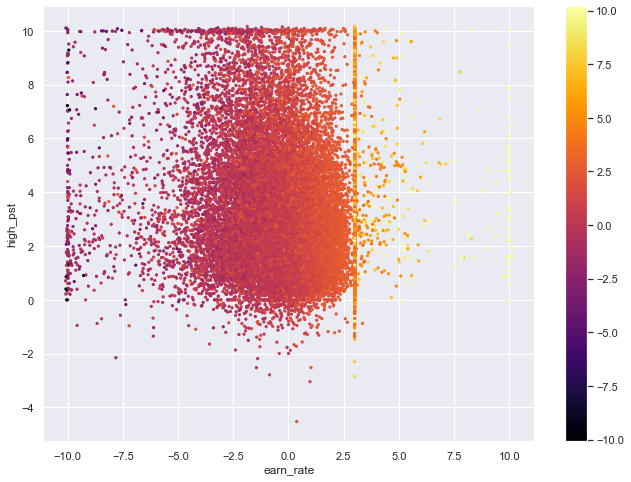

In [114]:
from mylab.pdplot.myplot import *
myScatter(all_df, col1 = "earn_rate", col2 = "high_pst", color = "postday_high_pst", save_dir = "./temp/")
# plt.ylim(2,3)

In [77]:
all_df.postday_close_pst.mean()

0.2214224584004815

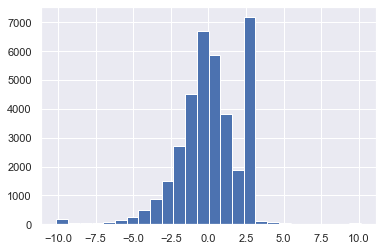

In [102]:
all_df.earn_rate.hist(bins = 26)

In [84]:
np.mean(all_df.postday_high_pst.values>1)

0.5516047228206037

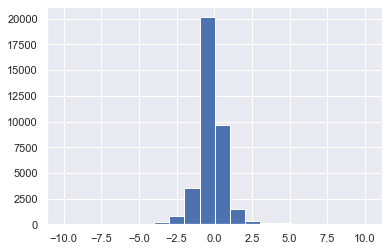

In [85]:
all_df.postday_open_pst.hist(bins = 20)

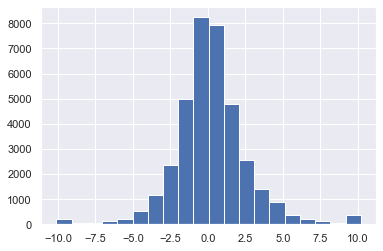

In [78]:
all_df.postday_close_pst.hist(bins = 20)

In [39]:

data_df = all_df.groupby('hold_period').agg({"earn_rate":np.mean,"earn_rate_per_day":np.mean,"win":np.mean})
data_df

,earn_rate,earn_rate_per_day,win
hold_period,,,
1.0,0.295713,0.295713,0.540890
2.0,0.160851,0.080425,0.527089
3.0,0.115335,0.038445,0.522478
4.0,0.035486,0.008871,0.512170


In [31]:
# 
temp_df = all_df.loc[all_df.hold_period.values ==1,:] 
temp_df.shape

(6861, 93)

In [93]:
1+reduce(lambda x, y: x+y, data_df.earn_rate_per_day.values[:]/100)

0.018684503612895642

(1718, 3)


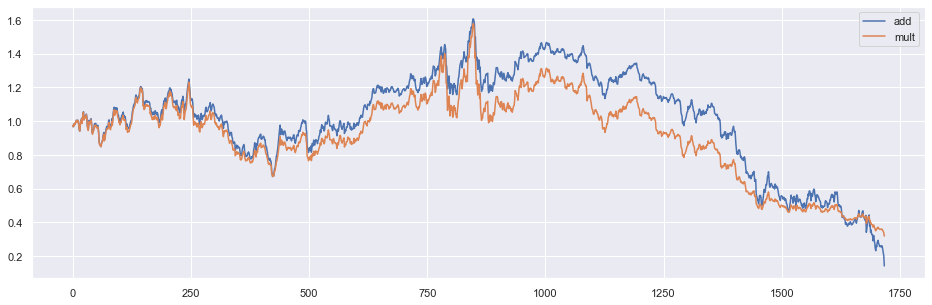

In [107]:
from functools import reduce  
temp_df = all_df.loc[all_df.hold_period.values ==1,:] 
data_df = temp_df.groupby('trade_date').agg({"earn_rate":np.mean,"earn_rate_per_day":np.mean})
data_df["earn_rate_add1"] = (data_df["earn_rate_per_day"]+100)/100
# data_df["earn_rate_acc"]
a = [1+reduce(lambda x, y: x+y, data_df.earn_rate_per_day.values[:i+1]/100) for i in range(len(data_df))] # len(data_df)
b = [reduce(lambda x, y: x*y, data_df.earn_rate_add1.values[:i+1]) for i in range(len(data_df))] # len(data_df)
print(data_df.shape)
plt.figure(figsize=(16,5))
plt.plot(a)
plt.plot(b)
plt.legend(["add","mult"])
plt.show()

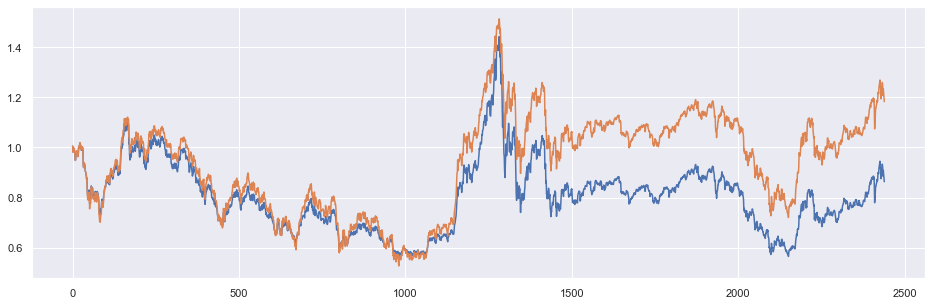

In [57]:
from mylab.stock.myread import getIndexDaily
index_df = getIndexDaily("399001.SZ", "20100303")
index_df["pct_chg_add1"] = (index_df["pct_chg"]+100)/100
b = [reduce(lambda x, y: x*y, index_df.pct_chg_add1.values[:i+1]) for i in range(len(index_df))] # len(data_df)
a = [1+reduce(lambda x, y: x+y, index_df.pct_chg.values[:i+1]/100) for i in range(len(index_df))] # len(data_df)
plt.figure(figsize=(16,5))
plt.plot(b)
plt.plot(a)

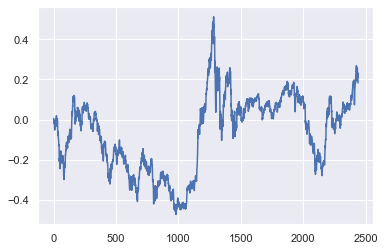

In [54]:
plt.plot(a)

In [38]:
index_df["pct_chg"].mean()

0.007478196721311477

In [ ]:
index_df = getIndexBasic()
index_df.head()